In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.io import wavfile as wv
from scipy.signal import iirfilter, lfilter, butter, freqz
from scipy.fftpack import fft
import sounddevice as sd
import string
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import os

sep = os.sep

sns.set(style='darkgrid', font_scale=1.5)
blue, red, green = sns.color_palette(n_colors=3)

# Pandas

[Pandas](http://pandas.pydata.org/) is a package designed to make data analysis easier and more efficient. Among the many things it can do, it makes it easy to read data from files, write data to files, and easily process data in various complicated ways. Conveniently, it comes bundled with Anaconda, so you already have it!

As coded above, it's standard to `import pandas as pd`, just like it's standard to `import numpy as np`.

The key object that you'll use in pandas is the `DataFrame`. There are a number of ways to create data frames "from scratch," and functions like `read_csv()` in pandas return data frames, as well. Within pandas, `DataFrame()` is a function (note the uppercase D and F), so, as usual, you can look at the doscstring to get a sense of how it works:

In [2]:
pd.DataFrame?

You can create a data frame in a number of ways. One is by giving `pd.DataFrame()` a dictionary as input:

In [3]:
x = np.random.normal(loc=-5, scale=3, size=100) # 100 random normal variates
y = 5 + 2*x + np.random.normal(size=100) # 100 more
letters = string.ascii_lowercase # lower case letters
z = [letters[np.random.randint(26)] for i in range(100)] # random letters
dd = {'x':x, 'y':y, 'z':z} # dictionary with x, y, and z
df_xyz = pd.DataFrame(dd) # data frame from dictionary
df_xyz.head(n=7) # first 5 rows

,x,y,z
0,-3.030925,0.446278,j
1,-6.706105,-8.092854,d
2,-10.179493,-15.734414,a
3,-1.760291,1.596255,t
4,-7.365768,-12.346446,u
5,-12.057102,-19.343769,z
6,-9.271387,-14.196804,v


Data frames have a shape attribute that tells you the number of rows and columns:

In [4]:
df_xyz.shape

(100, 3)

You can also create a data frame by initializing it as an empty data frame and then filling in data column by column:

In [5]:
df_uvw = pd.DataFrame()
df_uvw.head()

""


In [6]:
df_uvw['u'] = np.random.random(size=100) # column name 'u', value is 100 random numbers
df_uvw['v'] = 1/df_uvw['u'] # column name 'v', the reciprocal of column 'u'
df_uvw['w'] = [letters[np.random.randint(26)] for i in range(100)] # random letters
df_uvw.head()

,u,v,w
0,0.929583,1.075751,q
1,0.029232,34.209620,b
2,0.212767,4.699984,q
3,0.060155,16.623809,i
4,0.469499,2.129930,v


A very useful feature of data frames is the fact that different columns can contain different data types. In both of these toy examples, one column contains strings, while the other two contain numeric data.

In order to illustrate some more realistic uses for pandas, we will create a data frame (and do some signal processing) with the sound files we processed in the last notebook. In order to do that, we can use `glob()` (from the `glob` module) to get the list of sound files. Here's our current working directory:

Here's where the sound files are (on my computer) relative to the current working directory:

In [7]:
snd_dir = 'sentences' + sep

We can use `glob()` to read files from that folder:

In [8]:
snd_files = glob(snd_dir + '*.wav')
print(snd_files[:5])

['sentences/f7s2.wav', 'sentences/m9s4.wav', 'sentences/f1s4.wav', 'sentences/f1s5.wav', 'sentences/m9s5.wav']


Note that each file name includes the string indicating the relative folder location. We will be creating a dictionary to contain sound files we read it, and we will use the names of the sound files as the keys for the dictionary. In order to isolate the file names from the rest of the directory structure, we can use the `split()` method that strings have:

In [9]:
# separate a single filename's directories
file = snd_files[0]
file.split(sep)

['sentences', 'f7s2.wav']

In [10]:
# do the same for all the filenames, using a list comprehension
f_split = [ff.split(sep) for ff in snd_files]
f_split[:3]

[['sentences', 'f7s2.wav'],
 ['sentences', 'm9s4.wav'],
 ['sentences', 'f1s4.wav']]

Now we'll create a dictionary to hold the sound files, loop through the list of files, read each one, normalize its amplitude, get just the names of the sounds (i.e., get rid of the relative location and the file type extension "wav") and use them as keys:

In [11]:
snd_dict = {}

for file in snd_files:
    fs,s = wv.read(file) # read file in
    sname = file.split(sep)[-1].split('.')[0] # get file name, w/o .wav extension
    smax = np.max(np.abs(s)) # get peak amplitude
    s_norm = .975*s/smax # normalize w.r.t. peak amplitude
    snd_dict[sname] = s_norm # put the normalized vector in the dictionary
    snd_dict[sname + '_fs'] = fs # put the sampling frequency in the dictionary

print(snd_dict.keys())

dict_keys(['f7s2', 'f7s2_fs', 'm9s4', 'm9s4_fs', 'f1s4', 'f1s4_fs', 'f1s5', 'f1s5_fs', 'm9s5', 'm9s5_fs', 'f5s1', 'f5s1_fs', 'f7s3', 'f7s3_fs', 'f7s1', 'f7s1_fs', 'f5s3', 'f5s3_fs', 'f3s5', 'f3s5_fs', 'f3s4', 'f3s4_fs', 'f5s2', 'f5s2_fs', 'f7s4', 'f7s4_fs', 'm9s2', 'm9s2_fs', 'f1s2', 'f1s2_fs', 'f1s3', 'f1s3_fs', 'm9s3', 'm9s3_fs', 'f3s1', 'f3s1_fs', 'f7s5', 'f7s5_fs', 'f5s5', 'f5s5_fs', 'f3s3', 'f3s3_fs', 'm9s1', 'm9s1_fs', 'f1s1', 'f1s1_fs', 'f3s2', 'f3s2_fs', 'f5s4', 'f5s4_fs', 'f2s5', 'f2s5_fs', 'f4s3', 'f4s3_fs', 'f6s1', 'f6s1_fs', 'f4s2', 'f4s2_fs', 'f2s4', 'f2s4_fs', 'm8s4', 'm8s4_fs', 'f0s4', 'f0s4_fs', 'f6s2', 'f6s2_fs', 'f6s3', 'f6s3_fs', 'f4s1', 'f4s1_fs', 'f0s5', 'f0s5_fs', 'm8s5', 'm8s5_fs', 'm8s1', 'm8s1_fs', 'f0s1', 'f0s1_fs', 'f2s3', 'f2s3_fs', 'f4s5', 'f4s5_fs', 'f4s4', 'f4s4_fs', 'f2s2', 'f2s2_fs', 'm8s2', 'm8s2_fs', 'f0s2', 'f0s2_fs', 'f6s4', 'f6s4_fs', 'f6s5', 'f6s5_fs', 'f2s1', 'f2s1_fs', 'f0s3', 'f0s3_fs', 'm8s3', 'm8s3_fs', 'm6s1', 'm6s1_fs', 'm4s3', 'm4s3_fs', '

Okay, so now we will calculate some quantities (overall energy, high frequency energy, low frequency energy, duration), calculating the overall energy measure using two techniques, which we will then store in a data frame.

The two techniques will allow us to see how well [Parseval's theorem](https://en.wikipedia.org/wiki/Parseval%27s_theorem#Notation_used_in_physics) holds in the sound files in question. Parseval's theorem says that the "the total energy of a signal can be calculated by summing power-per-sample across time or spectral power across frequency":

\begin{equation*}
\sum_{n=0}^{N-1}|x[n]|^2 = \frac{1}{N}\sum_{k=0}^{N-1}|X[k]|^2
\end{equation*}


First, we'll get a list of just the keys for the sound arrays (not the sampling frequencies):

In [12]:
# list comprehension to get sound wave names (excluding _fs keys)
snames = [i for i in list(snd_dict.keys()) if '_fs' not in i]
snames.sort()
print(snames)

['f0s1', 'f0s2', 'f0s3', 'f0s4', 'f0s5', 'f1s1', 'f1s2', 'f1s3', 'f1s4', 'f1s5', 'f2s1', 'f2s2', 'f2s3', 'f2s4', 'f2s5', 'f3s1', 'f3s2', 'f3s3', 'f3s4', 'f3s5', 'f4s1', 'f4s2', 'f4s3', 'f4s4', 'f4s5', 'f5s1', 'f5s2', 'f5s3', 'f5s4', 'f5s5', 'f6s1', 'f6s2', 'f6s3', 'f6s4', 'f6s5', 'f7s1', 'f7s2', 'f7s3', 'f7s4', 'f7s5', 'f8s1', 'f8s2', 'f8s3', 'f8s4', 'f8s5', 'f9s1', 'f9s2', 'f9s3', 'f9s4', 'f9s5', 'm0s1', 'm0s2', 'm0s3', 'm0s4', 'm0s5', 'm1s1', 'm1s2', 'm1s3', 'm1s4', 'm1s5', 'm2s1', 'm2s2', 'm2s3', 'm2s4', 'm2s5', 'm3s1', 'm3s2', 'm3s3', 'm3s4', 'm3s5', 'm4s1', 'm4s2', 'm4s3', 'm4s4', 'm4s5', 'm5s1', 'm5s2', 'm5s3', 'm5s4', 'm5s5', 'm6s1', 'm6s2', 'm6s3', 'm6s4', 'm6s5', 'm7s1', 'm7s2', 'm7s3', 'm7s4', 'm7s5', 'm8s1', 'm8s2', 'm8s3', 'm8s4', 'm8s5', 'm9s1', 'm9s2', 'm9s3', 'm9s4', 'm9s5']


Next, we'll prepare for our calculations by creating a couple filters and a function for calculating RMS energy in a signal:

In [13]:
Nord = 5 # order of the filter
cut_freq = 500 # cutoff freq in Hz
nyq = fs/2 # nyquist, assumes all fs values were the same
cut_freq_rad = np.array([cut_freq/nyq]) # cutoff in radians
hi_b, hi_a = iirfilter(N=Nord, Wn=cut_freq_rad, btype='highpass') # high-pass filter
lo_b, lo_a = iirfilter(N=Nord, Wn=cut_freq_rad, btype='lowpass') # low-pass filter

In [14]:
iirfilter?

What about 500 Hz (or whatever cutoff frequency)? With Butterworth filters, the cutoff frequency is defined as the point that is -3 dB relative to the passband. Here's an illustration of the frequency response of these two filters:

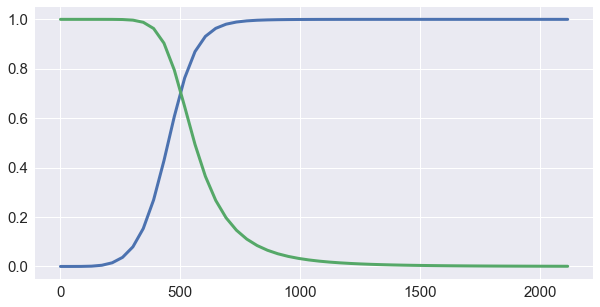

In [15]:
w_hi, H_hi = freqz(hi_b, hi_a) # frequency response of high pass filter
w_lo, H_lo = freqz(lo_b, lo_a) # frequency response of low pass filter
frq = np.linspace(0, nyq, len(w_hi))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(frq[:50], np.abs(H_hi)[:50], lw=3)
ax.plot(frq[:50], np.abs(H_lo)[:50], lw=3)

We'll define a convenience function for calculating RMS values:

In [16]:
def frms(x):
    return np.sqrt(np.mean(x**2))

Then we'll initialize our data frame:

In [17]:
n_snd = len(snames) # number of sound files we read in

# initialize data frame, specify index and columns
col_names = ['sex','talker','sentence_idx','rms','rms_lo','rms_hi','dur','pow_t','POW_f']
df_ac = pd.DataFrame(index=np.arange(n_snd), columns=col_names, dtype=float)

df_ac.head()

,sex,talker,sentence_idx,rms,rms_lo,rms_hi,dur,pow_t,POW_f
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_ac.shape

(100, 9)

Next, we'll loop through the `snd_dict` keys, extract each sound, and calculate a few things (note that this cell take a while to run):

In [19]:
for si, sn in enumerate(snames):
    if si % 25 == 0: # if si / 25 has a remainder of 0, then...
        print(si,sn)
    
    # sex, talker, sentence index
    sex = sn[0]
    talker = np.int(sn[1])
    sentence_idx = np.int(sn[3])
    
    # extract sound and fs from dictionary
    sound = snd_dict[sn]
    snd_fs = snd_dict[sn + '_fs']
    
    # filter the sound into high and low freq bands
    snd_hi = lfilter(hi_b, hi_a, sound)
    snd_lo = lfilter(lo_b, lo_a, sound)
    
    # calculate RMS energy values, duration
    rms_hi = frms(snd_hi)
    rms_lo = frms(snd_lo)
    rms = frms(sound)
    pow_t = np.sum(sound**2)
    dur = len(sound)/snd_fs
    
    # get FFT of signals to calculate mean squared spectral magnitudes
    POW_f = np.mean(np.abs(fft(sound))**2)
    
    # put the data into the data frame
    df_ac.loc[si,['sex','talker','sentence_idx']] = sex, talker, sentence_idx
    df_ac.loc[si,['rms','rms_hi','rms_lo']] = rms, rms_hi, rms_lo
    df_ac.loc[si,['dur','pow_t','POW_f']] = dur, pow_t, POW_f

0 f0s1
25 f5s1
50 m0s1
75 m5s1


It's often useful to use `head()` (or `tail()`) to quickly check to make sure things look sensible:

In [20]:
df_ac.head()

,sex,talker,sentence_idx,rms,rms_lo,rms_hi,dur,pow_t,POW_f
0,f,0.0,1.0,0.108575,0.068803,0.083991,2.155102,1120.376433,1120.376433
1,f,0.0,2.0,0.134131,0.103296,0.085564,2.805329,2225.782754,2225.782754
2,f,0.0,3.0,0.113871,0.092204,0.066821,2.961723,1693.595605,1693.595605
3,f,0.0,4.0,0.126026,0.096265,0.081337,2.205011,1544.438567,1544.438567
4,f,0.0,5.0,0.115549,0.082513,0.080890,2.417982,1423.713054,1423.713054


We can listen to the last sound and its filtered counterparts using `sounddevice`:

In [21]:
sd.play(sound)

In [22]:
sd.play(snd_hi)

In [23]:
sd.play(snd_lo)

There are a number of ways to access the data in a data frame. One way is to treat it like a dictionary and use a column name as we would use a key.

In [24]:
rms_vec = df_ac['rms']
rms_vec[:10]

0    0.108575
1    0.134131
2    0.113871
3    0.126026
4    0.115549
5    0.180859
6    0.178204
7    0.117745
8    0.145012
9    0.138330
Name: rms, dtype: float64

It is important to note that this does *not* give us back a numpy array. Rather, it gives us a pandas `Series` object (essentially, a 1D data frame):

In [25]:
type(rms_vec)

pandas.core.series.Series

If we want a numpy array, we can use the `values` attribute:

In [26]:
rms_npy = df_ac['rms'].values
rms_npy[:10]

array([ 0.10857473,  0.13413132,  0.11387105,  0.12602613,  0.11554879,
        0.18085918,  0.17820409,  0.11774473,  0.14501164,  0.13833032])

In [27]:
type(rms_npy)

numpy.ndarray

Series and data frames have lots of methods, including plotting methods, e.g.:

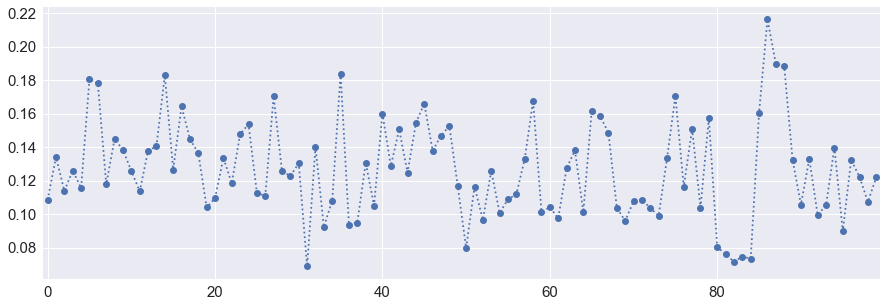

In [28]:
rms_vec.plot(style='o:',figsize=(15,5))
ax = plt.gca() # gca = get current axis object
ax.set_xlim(-.5,n_snd-.5);

As suggested by the use of column names to get data from a particular column, indexing with data frames is different than it is with numpy arrays. Whereas with a numpy array, we index rows and columns using slices (or boolean arrays), accessing specific rows in a data frame is very different.

Recall that the data frame has a component called the `index`. We can look at the index for a data frame like this:

In [29]:
df_ac.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')

In order to specify certain rows, we need to use `.loc` or `.iloc`. `.loc` uses labels (i.e., the specific values in the index), whereas `.iloc` uses position (specified by integers, as in numpy).

For our data frame, the index is just the set of integers indicating the positions of the rows, so none of this makes any difference. We'll come back to this later on, and illustrate the various methods. For now, it's just important to know that you don't just use numpy-like indexing.

So, if we want the first five rows of our data frame, and just the columns with RMS values in them, we would do this:

In [30]:
rms_0to4 = df_ac.loc[np.arange(5),['rms','rms_lo','rms_hi']]
rms_0to4

,rms,rms_lo,rms_hi
0,0.108575,0.068803,0.083991
1,0.134131,0.103296,0.085564
2,0.113871,0.092204,0.066821
3,0.126026,0.096265,0.081337
4,0.115549,0.082513,0.080890


We can use logical indexing with a numpy array of booleans to pick out rows, as well.

In [31]:
rows = (df_ac['rms'] < df_ac['rms'].median()).as_matrix() # converts Series (or data frame) to numpy array
print('boolean array:')
print(rows)
print('')
print('indices:')
print(df_ac.index[rows])
low_df = df_ac.loc[rows,:] # extract rows such that df['rms'] is in the bottom half of values
low_df.head()

boolean array:
[ True False  True False  True False False  True False False False  True
 False False False False False False False  True  True False  True False
 False  True  True False  True  True False  True False  True  True False
  True  True False  True False False False  True False False False False
 False  True  True  True  True False  True  True  True False False  True
  True  True False False  True False False False  True  True  True  True
  True  True False False  True False  True False  True  True  True  True
  True False False False False False  True False  True  True False  True
 False  True  True  True]

indices:
Int64Index([ 0,  2,  4,  7, 11, 19, 20, 22, 25, 26, 28, 29, 31, 33, 34, 36, 37,
            39, 43, 49, 50, 51, 52, 54, 55, 56, 59, 60, 61, 64, 68, 69, 70, 71,
            72, 73, 76, 78, 80, 81, 82, 83, 84, 90, 92, 93, 95, 97, 98, 99],
           dtype='int64')


,sex,talker,sentence_idx,rms,rms_lo,rms_hi,dur,pow_t,POW_f
0,f,0.0,1.0,0.108575,0.068803,0.083991,2.155102,1120.376433,1120.376433
2,f,0.0,3.0,0.113871,0.092204,0.066821,2.961723,1693.595605,1693.595605
4,f,0.0,5.0,0.115549,0.082513,0.080890,2.417982,1423.713054,1423.713054
7,f,1.0,3.0,0.117745,0.093373,0.071731,2.667302,1630.773684,1630.773684
11,f,2.0,2.0,0.113606,0.092579,0.065844,1.798481,1023.630586,1023.630586


In [32]:
low_df.shape

(50, 9)

The data frame `plot()` method can take multiple column names as arguments:

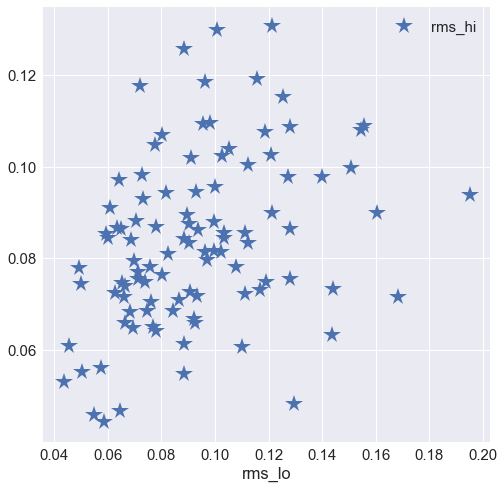

In [33]:
ax = df_ac.plot(x='rms_lo', y='rms_hi', style='*', ms=18, figsize=(8,8))

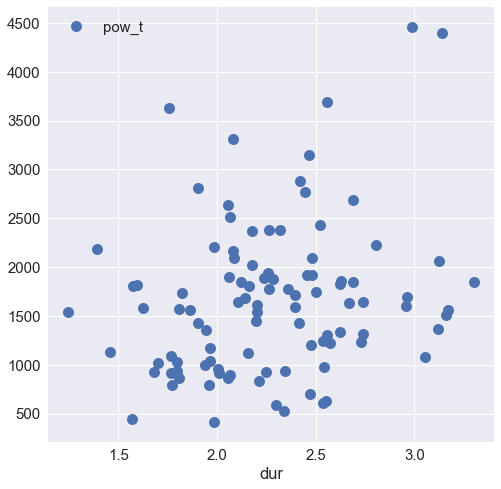

In [34]:
ax = df_ac.plot(x='dur', y='pow_t', style='o', ms=11, figsize=(8,8))

Or to make kernel density plots (smoothed histograms, with a bandwidth parameter that governs smoothness):

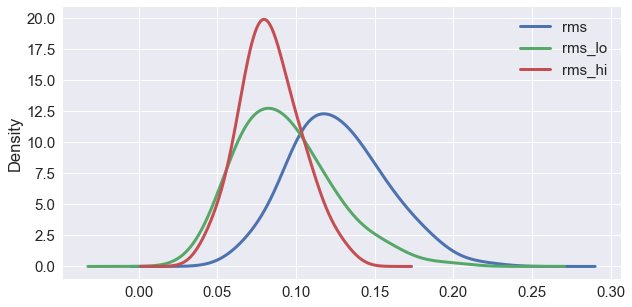

In [35]:
ax = df_ac.plot(y='rms',kind='kde', figsize=(10,5), lw=3, bw_method=.5)
ax = df_ac.plot(y='rms_lo',kind='kde', figsize=(10,5), lw=3, ax=ax, bw_method=.5)
ax = df_ac.plot(y='rms_hi',kind='kde', figsize=(10,5), lw=3, ax=ax, bw_method=.5)

Or histograms:

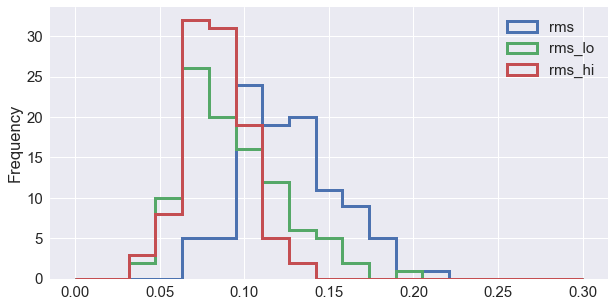

In [36]:
bins = np.linspace(0,.3,20)
ax = df_ac.plot(y='rms',kind='hist', histtype='step', figsize=(10,5), lw=3, bins=bins)
ax = df_ac.plot(y='rms_lo',kind='hist', histtype='step', figsize=(10,5), lw=3, bins=bins, ax=ax)
ax = df_ac.plot(y='rms_hi',kind='hist', histtype='step', figsize=(10,5), lw=3, bins=bins, ax=ax)

We can use visualize `pow_t` and `POW_f` to see if Parseval's theorem holds:

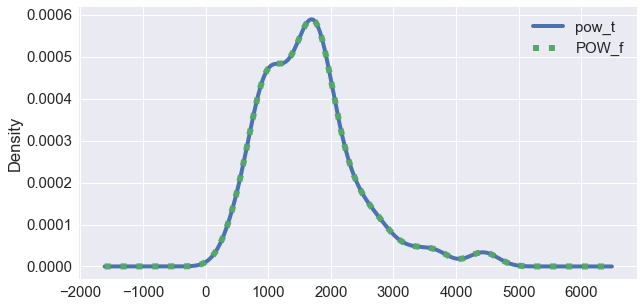

In [37]:
ax = df_ac.plot(y='pow_t', kind='kde', figsize=(10,5), lw=4, bw_method=.3)
ax = df_ac.plot(y='POW_f', kind='kde', style=':', figsize=(10,5), lw=6, bw_method=.3, ax=ax)

### Reading and writing data with pandas

Now that we have a data frame, we can easily save the data in it to a file on our computer. I typically use `csv` files for this, but there are multiple options.

In [38]:
df_ac.to_csv('sound_data.csv', index=False)
%ls # look at what's in the directory

Programming for CSD w08.ipynb  rms_data.npy
con_data_coda_dur.csv          sentences/
con_data_coda_pow.csv          snd_arrays.npz
con_data_onset_dur.csv         sound_data.csv
con_data_onset_pow.csv


As a brief aside, numpy also allows you to save data in arrays as files on your computer. These can take up a lot less space than pandas data frames, but pandas data frames can have columns of strings, numbers, etc, all in the same structure, plus you get convenient, easy to remember column names. (Numpy actually has a type of array that is a lot like a data frame, for what it's worth: [structured arrays](https://docs.scipy.org/doc/numpy/user/basics.rec.html).) 

Anyway, if you have exclusively numerical data, particularly if you have a large amount, and column names aren't particularly important (or if they are not important at all), you can use numpy to save data:

In [39]:
# use a list to pick out multiple columns
# make sure they are encoded as floats (.astype(float))
# make sure it's giving me a numpy array (.as_matrix())
snd_arr = df_ac[['rms','rms_lo','rms_hi']].astype(float).as_matrix() # extract RMS data as array of floats
np.save(file='rms_data.npy', arr=snd_arr)
%ls

Programming for CSD w08.ipynb  rms_data.npy
con_data_coda_dur.csv          sentences/
con_data_coda_pow.csv          snd_arrays.npz
con_data_onset_dur.csv         sound_data.csv
con_data_onset_pow.csv


In [40]:
snd_arr[:5,:]

array([[ 0.10857473,  0.06880308,  0.08399122],
       [ 0.13413132,  0.10329566,  0.08556398],
       [ 0.11387105,  0.09220396,  0.06682059],
       [ 0.12602613,  0.0962647 ,  0.08133681],
       [ 0.11554879,  0.08251279,  0.08088951]])

You can read (numpy) data in with numpy, too:

In [41]:
ac_arr = np.load(file='rms_data.npy')
ac_arr[:5,:]

array([[ 0.10857473,  0.06880308,  0.08399122],
       [ 0.13413132,  0.10329566,  0.08556398],
       [ 0.11387105,  0.09220396,  0.06682059],
       [ 0.12602613,  0.0962647 ,  0.08133681],
       [ 0.11554879,  0.08251279,  0.08088951]])

If you have multiple arrays, you can use the `savez()` function, and read structures saved this way with `load()`:

In [42]:
dur_arr = df_ac['dur'].as_matrix() # array with just durations
rms_arr = df_ac[['rms','rms_lo','rms_hi']].as_matrix() # rms array (again)
np.savez(file='snd_arrays.npz', dur_arr=dur_arr, rms_arr=rms_arr) # save both in a numpy zipped file
arrays = np.load(file='snd_arrays.npz') # returns dictionary-like object
print(type(arrays))
arrays.keys()

<class 'numpy.lib.npyio.NpzFile'>


['dur_arr', 'rms_arr']

Reading from `csv` (or many other files types) is easy with pandas. For example, we can read in a `csv` file with a couple of acoustic measurements for consonants produced 10 times by each of 20 talkers (10 male, 10 female) in onset position in simple CV or VC non-words:

In [43]:
pd.read_csv?

In [44]:
cod_df = pd.read_csv('con_data_onset_dur.csv') # cod = consonant onset duration
cod_df.head()

,consonant,voice,place,manner,prosody,condur,vowdur,subject,token
0,t,0,1,0,0,69,207,15,5
1,d,1,1,0,0,124,190,20,6
2,v,1,0,1,0,72,273,5,1
3,d,1,1,0,0,15,339,5,3
4,t,0,1,0,0,56,186,19,3


We can see which consonants are in this corpus by using the `unique()` function:

In [45]:
cod_df['consonant'].unique()

array(['t', 'd', 'v', 'b', 'f', 's', 'p', 'z'], dtype=object)

### Combining data sets with pandas

Pandas provides easy to use functions for combining data sets. The functions `concat()` concatenates data frames. In order to illustrate, we'll first read in some more data (one file with power measures for the same onset tokens, and two more with duration and power measurements for the same consonants produced in coda position).

In [46]:
ccd_df = pd.read_csv('con_data_coda_dur.csv') # ccd = consonant coda duration
cop_df = pd.read_csv('con_data_onset_pow.csv') # cop = consonant onset power
ccp_df = pd.read_csv('con_data_coda_pow.csv') # ccp = consonant coda power

We can combine the onset and coda duration data using `concat()` like this:

In [47]:
cd_df = pd.concat((cod_df,ccd_df),axis=0) # concatenate along rows, i.e., one on top of the other
print(cod_df['prosody'].unique()) # only onset (CV) data
print(ccd_df['prosody'].unique()) # only coda (VC) data
print(cd_df['prosody'].unique()) # 0 = onset (CV), 1 = coda (VC)
print(cod_df.shape, ccd_df.shape, cd_df.shape)
cd_df.head()

[0]
[1]
[0 1]
(1600, 9) (1600, 9) (3200, 9)


,consonant,voice,place,manner,prosody,condur,vowdur,subject,token
0,t,0,1,0,0,69,207,15,5
1,d,1,1,0,0,124,190,20,6
2,v,1,0,1,0,72,273,5,1
3,d,1,1,0,0,15,339,5,3
4,t,0,1,0,0,56,186,19,3


We can combine the onset and coda power data using `append()` like this (the end result is the same, whether you use `concat()` or `append()`):

In [48]:
cp_df = cop_df.append(ccp_df) # append ccp_df to cop_df
print(cop_df['prosody'].unique())
print(ccp_df['prosody'].unique())
print(cp_df['prosody'].unique())
print(cop_df.shape, ccp_df.shape, cp_df.shape)
cp_df.head()

[0]
[1]
[0 1]
(1600, 9) (1600, 9) (3200, 9)


,consonant,voice,place,manner,prosody,noipow,voipow,subject,token
0,f,0,0,1,0,148.82,109.75,9,7
1,b,1,0,0,0,132.41,110.67,12,3
2,v,1,0,1,0,135.85,116.97,20,9
3,b,1,0,0,0,138.93,129.70,13,3
4,d,1,1,0,0,145.15,131.58,19,3


We can now combine the duration and power data frames so that we have duration and power data for each unique production of each consonant. We'll use `merge()` to do this.

The function `merge()` can take a number of arguments, specifying exactly how the data frames to be merged should be combined. Here's the docstring for `merge()`:

In [49]:
pd.merge?

We can illustrate some options with a toy example:

In [50]:
df_a = pd.DataFrame({'name':['Bob','Mark','Jane','James','Fran','Erin'],
                     'job':['engineer','analyst','analyst','designer','designer','engineer'],
                     'level':['senior','senior','senior','junior','junior','junior']})
df_a

,job,level,name
0,engineer,senior,Bob
1,analyst,senior,Mark
2,analyst,senior,Jane
3,designer,junior,James
4,designer,junior,Fran
5,engineer,junior,Erin


In [51]:
df_b = pd.DataFrame({'job':['engineer','engineer','designer','designer','analyst','analyst','manager','manager'],
                     'level':['junior','senior','junior','senior','junior','senior','junior','senior'],
                     'salary':[55000, 63000, 37000, 45000, 62000, 77000, 88000, 94000]})
df_b

,job,level,salary
0,engineer,junior,55000
1,engineer,senior,63000
2,designer,junior,37000
3,designer,senior,45000
4,analyst,junior,62000
5,analyst,senior,77000
6,manager,junior,88000
7,manager,senior,94000


In [52]:
df_inner = pd.merge(left=df_a, right=df_b, on=['job','level'], how='inner') # inner is the default
df_inner

,job,level,name,salary
0,engineer,senior,Bob,63000
1,analyst,senior,Mark,77000
2,analyst,senior,Jane,77000
3,designer,junior,James,37000
4,designer,junior,Fran,37000
5,engineer,junior,Erin,55000


In [53]:
df_outer = pd.merge(left=df_a, right=df_b, on=['job','level'], how='outer')
df_outer

,job,level,name,salary
0,engineer,senior,Bob,63000
1,analyst,senior,Mark,77000
2,analyst,senior,Jane,77000
3,designer,junior,James,37000
4,designer,junior,Fran,37000
5,engineer,junior,Erin,55000
6,designer,senior,NaN,45000
7,analyst,junior,NaN,62000
8,manager,junior,NaN,88000
9,manager,senior,NaN,94000


We can use `merge()` to combine the duration and power data from above:

In [54]:
# this produces a data frame merged for each combination of suject, token, consonant, etc...
c_df = pd.merge(left=cd_df, right=cp_df, on=['subject','token','consonant','prosody','voice','place','manner'])
print(c_df.shape,cd_df.shape,cp_df.shape)
c_df.head()

(3200, 11) (3200, 9) (3200, 9)


,consonant,voice,place,manner,prosody,condur,vowdur,subject,token,noipow,voipow
0,t,0,1,0,0,69,207,15,5,148.03,113.20
1,d,1,1,0,0,124,190,20,6,142.55,116.38
2,v,1,0,1,0,72,273,5,1,130.04,106.54
3,d,1,1,0,0,15,339,5,3,141.05,115.92
4,t,0,1,0,0,56,186,19,3,141.98,118.25


### Creating new columns

Pandas allows you to create new columns easily. For a simple example, we can add the `noipow` and `voipow` columns together to get a total power column, we can add the `condur` and `vowdur` columns together to get a total duration column, and we can divide the `vowdur` column by the `condur` column to get a measure of the consonant duration as a proportion of the vowel duration:

In [55]:
c_df['power'] = c_df['voipow'] + c_df['noipow']
c_df['duration'] = c_df['condur'] + c_df['vowdur']
c_df['cv_ratio'] = c_df['condur']/c_df['vowdur']
c_df.head()

,consonant,voice,place,manner,prosody,condur,vowdur,subject,token,noipow,voipow,power,duration,cv_ratio
0,t,0,1,0,0,69,207,15,5,148.03,113.20,261.23,276,0.333333
1,d,1,1,0,0,124,190,20,6,142.55,116.38,258.93,314,0.652632
2,v,1,0,1,0,72,273,5,1,130.04,106.54,236.58,345,0.263736
3,d,1,1,0,0,15,339,5,3,141.05,115.92,256.97,354,0.044248
4,t,0,1,0,0,56,186,19,3,141.98,118.25,260.23,242,0.301075


For a more complicated example, we may find it inconvenient that voicing, place, manner, and prosody (onset vs coda) are encoded with numbers in `c_df`. It would be nice to have words, instead.

Noting that 0 = voiceless, 1 = voiced; 0 = labial, 1 = alveolar; 0 = stop, 1 = fricative; and 0 = onset, 1 = coda, we can do the following:

In [56]:
v = ['voiceless','voiced'] # to be picked out with 0, 1 from voice column
p = ['labial','alveolar'] # to be picked out with 0, 1 from place column
m = ['stop','fricative'] # to be picked out with 0, 1 from manner column
s = ['onset','coda'] # to be picked out with 0, 1 from prosody column
labels = [v,p,m,s] # list of lists
cols_old = ['voice','place','manner','prosody'] # old column names
cols_new = ['vlab','plab','mlab','slab'] # column names for new corresponding labels

for lab_idx, old_new in enumerate(zip(cols_old,cols_new)):
    old_col, new_col = old_new
    c_df[new_col] = [labels[lab_idx][ii] for ii in c_df[old_col]]

c_df.head()

,consonant,voice,place,manner,prosody,condur,vowdur,subject,token,noipow,voipow,power,duration,cv_ratio,vlab,plab,mlab,slab
0,t,0,1,0,0,69,207,15,5,148.03,113.20,261.23,276,0.333333,voiceless,alveolar,stop,onset
1,d,1,1,0,0,124,190,20,6,142.55,116.38,258.93,314,0.652632,voiced,alveolar,stop,onset
2,v,1,0,1,0,72,273,5,1,130.04,106.54,236.58,345,0.263736,voiced,labial,fricative,onset
3,d,1,1,0,0,15,339,5,3,141.05,115.92,256.97,354,0.044248,voiced,alveolar,stop,onset
4,t,0,1,0,0,56,186,19,3,141.98,118.25,260.23,242,0.301075,voiceless,alveolar,stop,onset


If we only want the columns with labels, we can create a copy with just the subset of the columns that we want:

In [57]:
df = c_df[['consonant','condur','vowdur','subject','token',
           'noipow','voipow','power','duration','cv_ratio',
           'vlab','plab','mlab','slab']].copy()
df.head()

,consonant,condur,vowdur,subject,token,noipow,voipow,power,duration,cv_ratio,vlab,plab,mlab,slab
0,t,69,207,15,5,148.03,113.20,261.23,276,0.333333,voiceless,alveolar,stop,onset
1,d,124,190,20,6,142.55,116.38,258.93,314,0.652632,voiced,alveolar,stop,onset
2,v,72,273,5,1,130.04,106.54,236.58,345,0.263736,voiced,labial,fricative,onset
3,d,15,339,5,3,141.05,115.92,256.97,354,0.044248,voiced,alveolar,stop,onset
4,t,56,186,19,3,141.98,118.25,260.23,242,0.301075,voiceless,alveolar,stop,onset


In [58]:
df.shape

(3200, 14)

### Grouping and aggregating data

Pandas has some very nice methods for grouping data and calculating quantities for separate groups. The `groupby()` method creates a pandas object that can be easily used to, e.g., calculate group means for one or another variable.

In [59]:
con_grp = df.groupby('consonant') # creates grouped object
cd_m = con_grp['cv_ratio'].mean() # get mean consonant duration for each consonant
cd_m.sort_index(inplace=True) # sort the Series according to the index values
cd_m

consonant
b    0.376867
d    0.321414
f    0.778715
p    0.695786
s    0.820694
t    0.712429
v    0.428134
z    0.554214
Name: cv_ratio, dtype: float64

In this case, because we only picked out `cv_ratio`, we get a Series object back (i.e., a 1D pandas object):

In [60]:
type(cd_m)

pandas.core.series.Series

The `index` of this Series contains the consonants we're interested in:

In [61]:
cd_m.index

Index(['b', 'd', 'f', 'p', 's', 't', 'v', 'z'], dtype='object', name='consonant')

Using `.loc` with an index label gives the value at that labeled location in the Series:

In [62]:
cd_m.loc['p']

0.69578571439188197

If we use `.iloc`, we use an integer to indicate the location:

In [63]:
cd_m.iloc[3]

0.69578571439188197

In [64]:
cd_s = con_grp['cv_ratio'].std()
cd_s

consonant
b    0.326107
d    0.250537
f    0.385315
p    0.467467
s    0.307954
t    0.432348
v    0.210554
z    0.197720
Name: cv_ratio, dtype: float64

Reorder the rows:

In [65]:
cd_s = cd_s.loc[['p','b','t','d','f','v','s','z']] # rearrange the indices
cd_m = cd_m.loc[['p','b','t','d','f','v','s','z']] # rearrange the indices
cd_m

consonant
p    0.695786
b    0.376867
t    0.712429
d    0.321414
f    0.778715
v    0.428134
s    0.820694
z    0.554214
Name: cv_ratio, dtype: float64

In [66]:
cd_s

consonant
p    0.467467
b    0.326107
t    0.432348
d    0.250537
f    0.385315
v    0.210554
s    0.307954
z    0.197720
Name: cv_ratio, dtype: float64

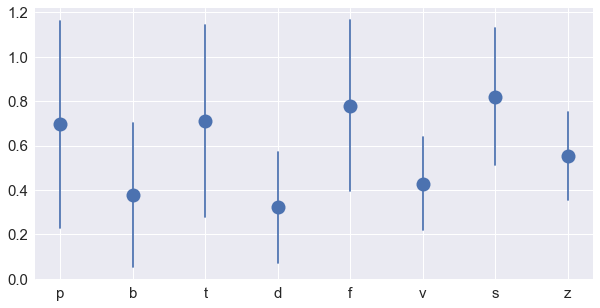

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
# plot error bars, means plus/minus one SD, using a list comprehension
[ ax.plot([i,i],[cd_m.loc[c]-cd_s.loc[c],cd_m.loc[c]+cd_s.loc[c]], color=blue) for i,c in enumerate(cd_m.index) ]
ax.plot(cd_m.values, 'o', color=blue, ms=14)
ax.set(xticks=np.arange(len(cd_m)),xticklabels=cd_m.index);

We can use `groupby()` to see if there is a difference in low or high frequency energy for male vs female speakers in the first (big) data frame we made:

In [68]:
# split by sex
# apply function mean() to columns rms, rms_lo, and rms_hi
# combine into single data frame
rms_x_sex = df_ac.groupby('sex')['rms','rms_lo','rms_hi'].mean()
rms_x_sex

,rms,rms_lo,rms_hi
sex,,,
f,0.132544,0.094859,0.090622
m,0.121019,0.091855,0.076840


You can group by multiple factors, as well. This will produce a 'MultiIndex', which is a more complex, structured index:

In [69]:
vpm_grp = df.groupby(['vlab','plab','mlab'])
np_vpm_m = vpm_grp[['noipow','voipow']].mean()
np_vpm_m

noipow      voipow
vlab      plab     mlab                             
voiced    alveolar fricative  153.385425  119.135290
                   stop       143.767275  118.632700
          labial   fricative  139.225450  116.452060
                   stop       134.981475  119.121375
voiceless alveolar fricative  156.090875  111.798450
                   stop       151.410000  114.313900
          labial   fricative  143.052025  110.670805
                   stop       139.160950  114.594375

We can use the `xs()` method to pick out particular rows (cross-sections) of a series or data frame with a multi-index. Note that the first argument (`key`) indicates the **value** of the index in the desired rows, while the second (`level`) indicates **the component of the multi-index** we want to use:

In [70]:
np_vpm_m.xs(key=('voiced','labial'), level=('vlab','plab'))

,noipow,voipow
mlab,,
fricative,139.225450,116.452060
stop,134.981475,119.121375


In [71]:
np_vpm_m.xs(key=('labial','fricative'), level=('plab','mlab'))

,noipow,voipow
vlab,,
voiced,139.225450,116.452060
voiceless,143.052025,110.670805


In [72]:
np_vpm_m.xs(key=('fricative'), level=('mlab'))

noipow      voipow
vlab      plab                            
voiced    alveolar  153.385425  119.135290
          labial    139.225450  116.452060
voiceless alveolar  156.090875  111.798450
          labial    143.052025  110.670805

Objects produced by `groupby()` have a number of aggregation functions:

| Function | Description |
|:-:|:-:|
| `count()`| total number of elements|
| `first()`, `last()` | first, last element |
| `mean()`, `median()` | mean, median of all elements |
| `min()`, `max()` | minimum, maximum |
| `std()`, `var()` | standard deviation, variance |
| `mad()` | mean absolute deviation |
| `prod()`, `sum()` | product, sum of elements |

In [73]:
vpm_grp[['condur','vowdur','noipow','voipow']].first()

condur  vowdur  noipow  voipow
vlab      plab     mlab                                     
voiced    alveolar fricative     100     240  147.60  121.62
                   stop          124     190  142.55  116.38
          labial   fricative      72     273  130.04  106.54
                   stop           32     199  133.75  119.19
voiceless alveolar fricative     166     312  160.93  106.69
                   stop           69     207  148.03  113.20
          labial   fricative     137     191  149.72  113.20
                   stop           65     349  144.74  111.00

In [74]:
vpm_grp[['condur','vowdur','noipow','voipow']].median()

condur  vowdur   noipow   voipow
vlab      plab     mlab                                       
voiced    alveolar fricative   152.5   280.0  153.230  120.230
                   stop         83.0   264.0  143.680  118.365
          labial   fricative   119.0   280.0  138.770  116.770
                   stop         94.0   250.0  135.100  119.025
voiceless alveolar fricative   192.5   250.5  156.775  111.665
                   stop        125.5   208.0  152.200  114.390
          labial   fricative   178.5   239.5  142.970  110.680
                   stop        115.5   199.0  139.685  114.260

In [75]:
vpm_grp[['condur','vowdur','noipow','voipow']].mad()

condur     vowdur    noipow    voipow
vlab      plab     mlab                                               
voiced    alveolar fricative  42.489250  38.935500  5.822456  4.639175
                   stop       53.838188  35.269725  6.425098  4.269581
          labial   fricative  45.301200  41.425675  5.546345  4.998877
                   stop       65.306150  39.917800  5.257453  4.659839
voiceless alveolar fricative  42.895000  43.912625  5.633051  3.879469
                   stop       59.992125  37.252175  6.041000  4.161411
          labial   fricative  49.982062  40.775100  5.278545  3.890791
                   stop       52.976500  43.948625  5.937279  4.399900

In [76]:
vpm_grp[['condur','vowdur','noipow','voipow']].count()

condur  vowdur  noipow  voipow
vlab      plab     mlab                                     
voiced    alveolar fricative     400     400     400     400
                   stop          400     400     400     400
          labial   fricative     400     400     400     400
                   stop          400     400     400     400
voiceless alveolar fricative     400     400     400     400
                   stop          400     400     400     400
          labial   fricative     400     400     400     400
                   stop          400     400     400     400

Pandas also enables easy creation of cross-tabulations (i.e., sums of co-occurences of given factors):

In [77]:
# new column indicating greater than average noise power
df['high_noipow'] = df['noipow'] > df['noipow'].mean()
pd.crosstab(df['vlab'],df['high_noipow'], margins=True)#, normalize=True)

high_noipow,False,True,All
vlab,,,
voiced,978,622,1600
voiceless,671,929,1600
All,1649,1551,3200


Cross-tabs can involve more than just two factors:

In [78]:
pd.crosstab(df['vlab'],[ df['mlab'], df['high_noipow'] ]) #, margins=True)

mlab        fricative        stop      
high_noipow     False True  False True 
vlab                                   
voiced            372   428   606   194
voiceless         277   523   394   406

In [79]:
pd.crosstab(df['vlab'],[df['plab'],df['mlab'],df['high_noipow']])

plab         alveolar                      labial                  
mlab        fricative        stop       fricative        stop      
high_noipow     False True  False True      False True  False True 
vlab                                                               
voiced             49   351   230   170       323    77   376    24
voiceless          24   376    82   318       253   147   312    88

You can also give `crosstab()` an aggregation function if you don't want a sum:

In [80]:
pd.crosstab(c_df['vlab'],c_df['plab'], aggfunc=np.std, values=c_df['condur'])

plab,alveolar,labial
vlab,,
voiced,68.630335,65.485337
voiceless,68.025541,66.529675


Finally, pandas makes it pretty easy to reshape data sets. The data frame `df` is currently in "long" format:

In [81]:
df.sort_values(['subject','consonant','token']).head()

,consonant,condur,vowdur,subject,token,noipow,voipow,power,duration,cv_ratio,vlab,plab,mlab,slab,high_noipow
1164,b,15,184,1,1,138.55,119.30,257.85,199,0.081522,voiced,labial,stop,onset,False
2105,b,108,214,1,1,142.09,117.84,259.93,322,0.504673,voiced,labial,stop,coda,False
163,b,9,196,1,2,144.49,119.96,264.45,205,0.045918,voiced,labial,stop,onset,False
3164,b,102,229,1,2,135.18,118.60,253.78,331,0.445415,voiced,labial,stop,coda,False
751,b,13,245,1,3,136.56,118.80,255.36,258,0.053061,voiced,labial,stop,onset,False


We can specify one or more columns to be the (multi)index of a pivot table, putting the data into "wide" format:

In [82]:
pd.pivot_table?

In [83]:
pt_a = pd.pivot_table(data=df, index=df[['subject','vlab','slab']]) # values are means by default
pt_a.head(n=17)

condur  cv_ratio  duration  high_noipow     noipow  \
subject vlab      slab                                                         
1       voiced    coda   138.775  0.560329   385.375        0.325  142.52675   
                  onset   88.100  0.459988   286.425        0.550  146.64950   
        voiceless coda   191.325  1.078630   370.400        0.825  151.56200   
                  onset  112.175  0.636929   291.500        0.775  154.00950   
2       voiced    coda   174.800  0.712401   419.175        0.475  144.50400   
                  onset   46.550  0.160387   348.800        0.225  136.83850   
        voiceless coda   239.800  1.143311   452.625        0.550  147.20925   
                  onset  102.400  0.351785   393.950        0.550  144.89600   
3       voiced    coda   197.850  0.667237   497.775        0.325  141.97125   
                  onset   70.200  0.211163   408.175        0.325  143.15550   
        voiceless coda   223.825  0.893363   486.350        0.725  148.16750   
                  onset  128.700  0.409584   448.275        0.650  149.56625   
4       voiced    coda   134.425  0.498461   402.625        0.375  141.74600   
                  onset   58.600  0.215338   331.975        0.325  142.76500   
        voiceless coda   189.575  0.821281   425.650        0.525  145.47025   
                  onset   96.400  0.365385   362.300        0.675  149.54350   
5       voiced    coda   137.200  0.479444   423.875        0.000  128.16900   

                             power  token     voipow   vowdur  
subject vlab      slab                                         
1       voiced    coda   261.26350    5.5  118.73675  246.600  
                  onset  268.28150    5.5  121.63200  198.325  
        voiceless coda   266.86775    5.5  115.30575  179.075  
                  onset  269.87300    5.5  115.86350  179.325  
2       voiced    coda   260.56900    5.5  116.06500  244.375  
                  onset  246.06775    5.5  109.22925  302.250  
        voiceless coda   255.81900    5.5  108.60975  212.825  
                  onset  254.01600    5.5  109.12000  291.550  
3       voiced    coda   263.58725    5.5  121.61600  299.925  
                  onset  259.77150    5.5  116.61600  337.975  
        voiceless coda   265.43825    5.5  117.27075  262.525  
                  onset  263.53775    5.5  113.97150  319.575  
4       voiced    coda   259.09550    5.5  117.34950  268.200  
                  onset  263.33275    5.5  120.56775  273.375  
        voiceless coda   262.18425    5.5  116.71400  236.075  
                  onset  267.39525    5.5  117.85175  265.900  
5       voiced    coda   237.73475    5.5  109.56575  286.675

In [84]:
pt_b = pd.pivot_table(data=df, index=df[['subject','vlab','slab']], aggfunc=np.min) # use min instead
pt_b.head(n=15)

condur consonant  cv_ratio  duration  high_noipow  \
subject vlab      slab                                                       
1       voiced    coda       74         b  0.344000       288        False   
                  onset       9         b  0.045918       199        False   
        voiceless coda      102         f  0.582474       239        False   
                  onset      32         f  0.216216       180        False   
2       voiced    coda       75         b  0.318367       277        False   
                  onset       5         b  0.016077       277        False   
        voiceless coda      107         f  0.569149       295        False   
                  onset      45         f  0.163009       293        False   
3       voiced    coda       82         b  0.273006       351        False   
                  onset      10         b  0.027295       285        False   
        voiceless coda      157         f  0.544413       328        False   
                  onset      56         f  0.184697       314        False   
4       voiced    coda       53         b  0.204633       238        False   
                  onset       4         b  0.012121       232        False   
        voiceless coda      109         f  0.442529       223        False   

                              mlab  noipow      plab    power  token   voipow  \
subject vlab      slab                                                          
1       voiced    coda   fricative  125.93  alveolar  242.080      1  108.470   
                  onset  fricative  124.43  alveolar  245.810      1  105.420   
        voiceless coda   fricative  136.13  alveolar  250.340      1  105.930   
                  onset  fricative  138.81  alveolar  254.710      1  108.600   
2       voiced    coda   fricative  120.68  alveolar  234.970      1  107.180   
                  onset  fricative  122.14  alveolar  225.984      1   97.624   
        voiceless coda   fricative  128.33  alveolar  232.820      1  101.150   
                  onset  fricative  129.37  alveolar  230.310      1  100.470   
3       voiced    coda   fricative  129.07  alveolar  250.640      1  114.100   
                  onset  fricative  123.35  alveolar  239.470      1  107.380   
        voiceless coda   fricative  136.77  alveolar  248.730      1  109.890   
                  onset  fricative  134.38  alveolar  240.130      1  102.230   
4       voiced    coda   fricative  127.80  alveolar  239.470      1  111.520   
                  onset  fricative  130.00  alveolar  246.430      1  112.770   
        voiceless coda   fricative  130.19  alveolar  244.360      1  109.860   

                         vowdur  
subject vlab      slab           
1       voiced    coda      195  
                  onset     149  
        voiceless coda      125  
                  onset     131  
2       voiced    coda      197  
                  onset     219  
        voiceless coda      152  
                  onset     240  
3       voiced    coda      208  
                  onset     265  
        voiceless coda      160  
                  onset     160  
4       voiced    coda      138  
                  onset     213  
        voiceless coda      114

We can also specify what we want in the columns:

In [85]:
pt_c = pd.pivot_table(data=df, index=df[['subject','vlab','slab']], columns=df['token'])
pt_c.head(n=15)

condur                                          \
token                        1       2       3       4       5       6    
subject vlab      slab                                                    
1       voiced    coda   141.75  118.75  133.00  154.75  151.25  151.25   
                  onset   58.00   64.25   56.00  102.25   94.75  114.50   
        voiceless coda   177.75  154.00  206.50  174.75  217.75  194.75   
                  onset  100.50  121.25  105.50  107.75  125.25  102.75   
2       voiced    coda   217.00  206.50  228.00  154.00  162.00  158.00   
                  onset   33.25   44.50   69.00   54.50   39.25   54.00   
        voiceless coda   268.25  278.75  242.50  233.50  229.25  235.25   
                  onset  112.25  101.25   94.75   86.25  112.50   95.75   
3       voiced    coda   243.50  240.00  201.00  187.50  154.00  162.00   
                  onset   36.25   62.50   74.00   69.75   92.75   56.00   
        voiceless coda   213.75  236.50  216.25  223.00  210.75  224.00   
                  onset  133.75  129.75  127.25  112.75  131.25  120.75   
4       voiced    coda   156.50  136.75  125.75  133.00  129.75  141.00   
                  onset   77.50   62.50   84.75   34.25   42.50   53.50   
        voiceless coda   198.75  192.50  211.50  189.25  171.75  181.50   

                                                          ...    vowdur  \
token                        7       8       9       10   ...        1    
subject vlab      slab                                    ...             
1       voiced    coda   117.75  147.00  140.25  132.00   ...    242.00   
                  onset  109.75   59.75  113.50  108.25   ...    190.50   
        voiceless coda   199.25  195.25  204.00  189.25   ...    178.75   
                  onset  115.75  112.00  108.00  123.00   ...    176.25   
2       voiced    coda   149.25  135.00  176.00  162.25   ...    265.50   
                  onset   50.75   31.75   44.50   44.00   ...    325.00   
        voiceless coda   247.75  203.50  240.50  218.75   ...    213.25   
                  onset  105.25  110.25  109.00   96.75   ...    283.25   
3       voiced    coda   206.25  255.50  182.00  146.75   ...    262.75   
                  onset   75.00   98.75   54.75   82.25   ...    333.25   
        voiceless coda   230.25  213.75  258.00  212.00   ...    266.50   
                  onset  114.00  160.50  124.50  132.50   ...    327.75   
4       voiced    coda   141.25  117.25  126.75  136.25   ...    273.50   
                  onset   55.25   60.00   42.00   73.75   ...    262.75   
        voiceless coda   175.25  190.50  179.25  205.50   ...    248.00   

                                                                         \
token                        2       3       4       5       6       7    
subject vlab      slab                                                    
1       voiced    coda   260.00  246.50  245.00  271.50  264.75  260.50   
                  onset  216.25  241.75  204.75  215.00  198.25  185.25   
        voiceless coda   198.75  175.75  181.50  165.00  188.25  182.00   
                  onset  199.50  209.25  180.75  194.25  185.00  178.25   
2       voiced    coda   241.50  256.75  258.50  225.00  246.25  224.75   
                  onset  296.00  271.00  271.50  293.50  292.00  307.75   
        voiceless coda   198.75  235.25  212.75  210.50  217.25  201.50   
                  onset  275.25  298.00  266.25  284.00  285.50  292.25   
3       voiced    coda   268.00  277.25  330.25  314.00  310.00  306.00   
                  onset  356.50  332.00  298.00  341.00  382.50  363.75   
        voiceless coda   221.25  265.25  261.25  236.50  292.50  271.25   
                  onset  269.75  321.50  279.25  298.75  345.75  347.00   
4       voiced    coda   287.25  264.25  222.25  280.25  255.00  275.00   
                  onset  254.25  257.25  254.25  270.50  261.75  292.25   
        voiceless coda   242.25  249.75  224.00 

In [86]:
pt_c.shape

(80, 80)

We can specify the columns to use to calculate the values in the pivot table:

In [87]:
pt_d = pd.pivot_table(data=df, index=['subject','vlab','slab'],
                      columns=['token'],
                      values=['cv_ratio'])
pt_d.columns = [col[0] + '_' + str(col[1]) for col in pt_d.columns.values] # flatten the column names
pt_d.head(n=15)

cv_ratio_1  cv_ratio_2  cv_ratio_3  cv_ratio_4  \
subject vlab      slab                                                    
1       voiced    coda     0.583078    0.455931    0.525416    0.629653   
                  onset    0.318919    0.282757    0.234897    0.500029   
        voiceless coda     0.997439    0.775209    1.196155    0.964193   
                  onset    0.567813    0.640890    0.486317    0.625741   
2       voiced    coda     0.836890    0.856554    0.918949    0.575108   
                  onset    0.098384    0.159040    0.269337    0.207857   
        voiceless coda     1.313157    1.409309    1.039688    1.088498   
                  onset    0.392752    0.356906    0.333619    0.324596   
3       voiced    coda     0.926515    0.896046    0.735651    0.582731   
                  onset    0.113681    0.176798    0.224951    0.251962   
        voiceless coda     0.821409    1.078054    0.842764    0.873971   
                  onset    0.405652    0.533268    0.405077    0.404869   
4       voiced    coda     0.550935    0.469016    0.467038    0.610325   
                  onset    0.295539    0.256876    0.333049    0.130422   
        voiceless coda     0.801065    0.792923    0.861390    0.855116   

                         cv_ratio_5  cv_ratio_6  cv_ratio_7  cv_ratio_8  \
subject vlab      slab                                                    
1       voiced    coda     0.547703    0.563647    0.450377    0.625114   
                  onset    0.436518    0.577126    0.595592    0.304166   
        voiceless coda     1.330838    1.061675    1.074545    1.067023   
                  onset    0.652222    0.535110    0.651831    0.753989   
2       voiced    coda     0.709897    0.641454    0.668996    0.570376   
                  onset    0.135024    0.177851    0.170586    0.099755   
        voiceless coda     1.094679    1.101654    1.253877    0.942783   
                  onset    0.389100    0.338093    0.357029    0.359695   
3       voiced    coda     0.503706    0.540360    0.679617    0.709610   
                  onset    0.263766    0.146262    0.225555    0.292875   
        voiceless coda     0.928339    0.833440    0.876295    0.802390   
                  onset    0.430014    0.348947    0.324564    0.474809   
4       voiced    coda     0.461748    0.553373    0.504880    0.462637   
                  onset    0.149795    0.192711    0.188729    0.213183   
        voiceless coda     0.718541    0.855965    0.712830    0.941783   

                         cv_ratio_9  cv_ratio_10  
subject vlab      slab                            
1       voiced    coda     0.612101     0.610270  
                  onset    0.681970     0.667903  
        voiceless coda     1.218618     1.100605  
                  onset    0.696300     0.759081  
2       voiced    coda     0.712317     0.633465  
                  onset    0.135319     0.150714  
        voiceless coda     1.198113     0.991353  
                  onset    0.359922     0.306141  
3       voiced    coda     0.590213     0.507926  
                  onset    0.175031     0.240752  
        voiceless coda     1.078587     0.798386  
                  onset    0.364532     0.404106  
4       voiced    coda     0.449670     0.454991  
                  onset    0.141787     0.251293  
        voiceless coda     0.771694     0.901506

We can also reshape in the other direction, going from "wide" to "long":

In [88]:
pd.melt?

In [89]:
pt_d.reset_index(inplace=True) # puts multi-index values into columns
pt_d.head()

,subject,vlab,slab,cv_ratio_1,cv_ratio_2,cv_ratio_3,cv_ratio_4,cv_ratio_5,cv_ratio_6,cv_ratio_7,cv_ratio_8,cv_ratio_9,cv_ratio_10
0,1,voiced,coda,0.583078,0.455931,0.525416,0.629653,0.547703,0.563647,0.450377,0.625114,0.612101,0.610270
1,1,voiced,onset,0.318919,0.282757,0.234897,0.500029,0.436518,0.577126,0.595592,0.304166,0.681970,0.667903
2,1,voiceless,coda,0.997439,0.775209,1.196155,0.964193,1.330838,1.061675,1.074545,1.067023,1.218618,1.100605
3,1,voiceless,onset,0.567813,0.640890,0.486317,0.625741,0.652222,0.535110,0.651831,0.753989,0.696300,0.759081
4,2,voiced,coda,0.836890,0.856554,0.918949,0.575108,0.709897,0.641454,0.668996,0.570376,0.712317,0.633465


In [90]:
df_z = pd.melt(frame=pt_d, id_vars=['subject','vlab','slab'],
               var_name='original', value_name='mean')
df_z.head(n=10)

,subject,vlab,slab,original,mean
0,1,voiced,coda,cv_ratio_1,0.583078
1,1,voiced,onset,cv_ratio_1,0.318919
2,1,voiceless,coda,cv_ratio_1,0.997439
3,1,voiceless,onset,cv_ratio_1,0.567813
4,2,voiced,coda,cv_ratio_1,0.836890
5,2,voiced,onset,cv_ratio_1,0.098384
6,2,voiceless,coda,cv_ratio_1,1.313157
7,2,voiceless,onset,cv_ratio_1,0.392752
8,3,voiced,coda,cv_ratio_1,0.926515
9,3,voiced,onset,cv_ratio_1,0.113681


## Summary



This notebook covers the basic capabilities of pandas data frames. We saw how to create data frames and how indexing in data frames is different from indexing in numpy arrays. We saw how some basic signal processing can be used in conjunction with data frames to take acoustic measurements and store the results in a convenient format. We showed how to read and write data with data frames (as well as with numpy arrays), and we used pandas to visualize data, combine data from different sources, and reshape data frames from long to wide format and back again.